In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

https://mc-stan.org/users/documentation/case-studies/tutorial_twopl.html#discrepancy-measures-for-irt-model-checking 

don't need a summary statistic. 

doi.org/10.1177/0146621605285517

## Section 1: Model diagnostics

### 1.1 Total score distribution

Model 1: X2 = 58.842 (ppp-value = 0.877)
Model 2: X2 = 47.394 (ppp-value = 0.708)
Model 3: X2 = 47.740 (ppp-value = 0.671)


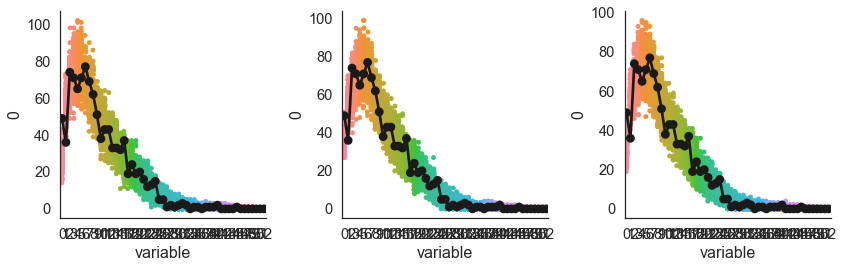

In [2]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

## Main loop.
for ax, m in zip(axes, [1,2,3]):
    
    ## Load PPMC.
    df = read_csv(os.path.join('stan_results', f'2plq_m{m}_ppmc1.csv'), index_col=0)

    ## Extract values.
    NC  = df.values[0]
    NCr = df.values[1:]
    ENC = NCr.mean(axis=0)
    
    ## Compute chi-square statistics.
    xi = np.sum(np.divide(np.square(NC - ENC), ENC, where=ENC > 0))
    xr = np.divide(np.square(NCr - ENC), ENC, where=ENC > 0).sum(axis=1)
    
    ## Compute ppp-value.
    pppv = (xi >= xr).mean()
    
    ## Print result.
    print('Model %s: X2 = %0.3f (ppp-value = %0.3f)' %(m, xi, pppv))
    
    ## Plot.
    sns.stripplot(x='variable', y='value', data=df.loc[1::20].melt(), zorder=-1, ax=ax)
    sns.pointplot(x=df.columns, y=df.loc[0], color='k', ax=ax)
    
sns.despine()
plt.tight_layout()

#### 1.2 Item covariance

#### 1.3 Local dependence

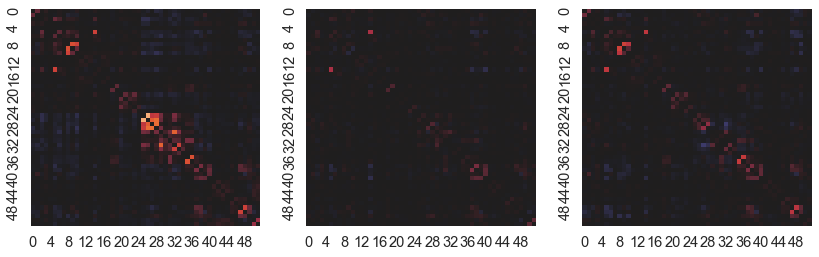

In [3]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(14,4))

## Main loop.
for ax, m in zip(axes, [1,2,3]):
    
    ## Load PPMC.
    df = read_csv(os.path.join('stan_results', f'2plq_m{m}_ppmc3.csv')).tail(-1)
    
    ## Prepare conditional covariance.
    ccov = np.identity(df.k1.nunique()+1) * 0.0
    ccov[df.k1, df.k2] = ccov[df.k2, df.k1] = df.stat
    
    ## Plot
    sns.heatmap(ccov, center=0, vmin=-0.1, vmax=0.1, cbar=False, ax=ax)

## Section 2: Model comparison

In [4]:
for i, m in enumerate(['2plq_m1','2plq_m2','2plq_m3']):
    
    ## Load ppc.
    ppc = read_csv(os.path.join('stan_results', f'{m}_ppmc0.csv'))
        
    ## Model comparison.
    loo = ppc.groupby('subject').loo.mean().sum()
    
    print('%s: %0.2f' %(m, loo))

2plq_m1: -323.65
2plq_m2: -282.39
2plq_m3: -301.66


In [5]:
from itertools import combinations

for a, b in list(combinations(['2plq_m1','2plq_m2','2plq_m3'], 2)):
    
    ## Load data.
    df1 = read_csv(os.path.join('stan_results', f'{a}_ppmc0.csv'))
    df2 = read_csv(os.path.join('stan_results', f'{b}_ppmc0.csv'))
    
    arr = df2.groupby('subject').loo.mean() - df1.groupby('subject').loo.mean()
    
    ## Compute stats.
    N = len(df1)
    mu = np.sum(arr)
    se = np.std(arr) * np.sqrt(N)
    
    print(f'{b} - {a}: %0.2f (%0.2f)' %(mu, se))

2plq_m2 - 2plq_m1: 41.26 (12.73)
2plq_m3 - 2plq_m1: 21.99 (10.51)
2plq_m3 - 2plq_m2: -19.27 (10.88)
